Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [x] Fit a model. Does it beat your baseline? 
- [x] Try xgboost.
- [x] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

## Import DataSet

In [0]:
#import file
import pandas as pd
import numpy as np
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv')
print(df.shape)
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install eli5

In [71]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    # Three way split using a function I found at 
    #   https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    #   by user piRSquared

    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, val, test = train_validate_test_split(df, seed=35177)

print(train.shape, val.shape, test.shape)

import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(train,minimal=True)

# profile.to_notebook_iframe()
profile.to_file(output_file='epeleptic_seizure_data_profile.html')

(6900, 180) (2300, 180) (2300, 180)


## Wrangle the data

In [0]:
# defining functions to split the Unnamed: 0 column into something that should 
#  hopefully be useful.
def split_string_X(mystring):
  values = mystring.split('.')
  values = values[0].split('X')
  return values[1]

def split_string_V(mystring):
  values = mystring.split('.')
  values = values[1].split('V')
  return values[1]

def split_string_end(mystring):
  values = mystring.split('.')
  try:
    values[2]
  except:
    return 0
  return values[2]

In [73]:
def wrangle(X):
  X = X.copy()

  # divide "Unamed: 0" into three coulns with the . as the 
  #   seperator
  X['V_id'] = X['Unnamed: 0'].apply(split_string_V)
  X['X_id'] = X['Unnamed: 0'].apply(split_string_X)
  X['data_point'] = X['Unnamed: 0'].apply(split_string_end)
  
  X = X.drop(columns='Unnamed: 0')

  # replace the y with seizure column as the target to
  #  make this a binary classification problem
  X.loc[X['y']==1, 'seizure'] = 1
  X.loc[X['y']!=1, 'seizure'] = 0
  X = X.drop(columns='y')
  
  return X

w_train = wrangle(train)
w_val = wrangle(val)
w_test = wrangle(test)


w_train.shape, w_val.shape, w_test.shape

((6900, 182), (2300, 182), (2300, 182))

In [0]:
target = 'seizure'
features = w_train.drop(columns=target).columns.tolist()

X_train = w_train[features]
y_train = w_train[target]
X_val = w_val[features]
y_val = w_val[target]
X_test = w_test[features]
y_test = w_test[target]

## Make a simple pipeline using the Random Forest Classifier

In [78]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    #SimpleImputer(strategy='median'), # No NaN values so not needed.
    RandomForestClassifier(max_depth=10,random_state=7,
                           criterion='entropy')
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy:',pipeline.score(X_val,y_val))

from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
y_pred_proba
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy: 0.9630434782608696
AUC ROC Score: 0.9951942330796956


With a baseline of 80% accuracy, 96% is pretty good.

AUC ROC seems like it could be too high

## Check out the (Default) Feature Importances

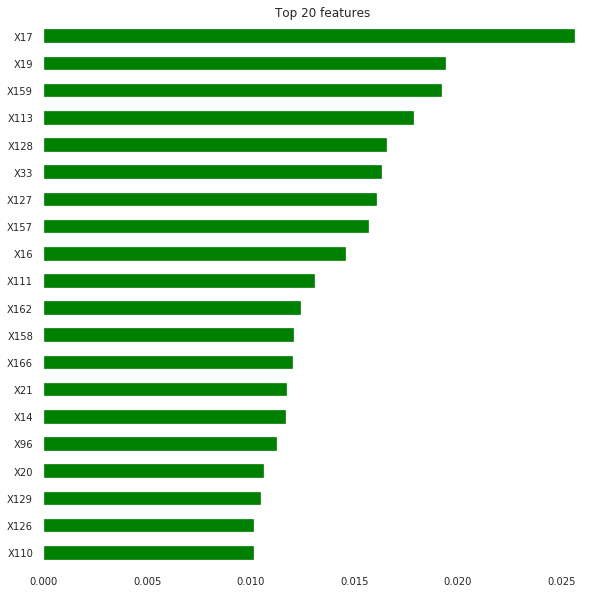

In [79]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

# I want to look at the top 20 features
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='green');

## Use Permutation Importances

In [81]:
# separate the pipeline out  so that we can use the
# Permutation importance
transformers = make_pipeline(
                ce.OrdinalEncoder()
                              )
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(max_depth=10,random_state=7,
                               criterion='entropy')
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [82]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=7,
    random_state=7
)

permuter.fit(X_val_transformed,y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=10,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_f

In [83]:
# set feature names to a variable
feature_names = X_val.columns.tolist()
# show the weights for each column
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0009 ± 0.0007,X67
0.0007 ± 0.0009,X91
0.0007 ± 0.0004,X133
0.0006 ± 0.0006,X140
0.0006 ± 0.0006,X79
0.0005 ± 0.0007,X86
0.0005 ± 0.0006,X112
0.0005 ± 0.0013,X113
0.0005 ± 0.0009,X16
0.0004 ± 0.0005,X95


In [84]:
# remove all the noise that has an importance of 0 or less
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train[features].shape

(6900, 45)

In [85]:
# Reset all the X matricies to not include the noise
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

print(X_train.shape,X_val.shape,X_test.shape)

(6900, 45) (2300, 45) (2300, 45)


## Try the Random Forest again to look at the new score

In [86]:
pipeline = make_pipeline(
    #ce.OrdinalEncoder(),
    #SimpleImputer(strategy='median'), # No NaN values so not needed.
    RandomForestClassifier(max_depth=15,random_state=7,
                           criterion='entropy')
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy:',pipeline.score(X_val,y_val))

y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
y_pred_proba
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy: 0.9695652173913043
AUC ROC Score: 0.9941571931772673


In [0]:
# looks like it's not much of a change, but hopefully it helped with overfitting a bit

## Try out XGBoost to look at the new scores

In [106]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val,y_pred))
y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
y_pred_proba
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))


Validation Accuracy: 0.9656521739130435
AUC ROC Score: 0.9931281173772162


### XGBoost with early stopping

In [108]:
model = XGBClassifier(
    n_estimators=1000, # don't expect to get that high because of early stopping
    max_depth = 7,
    learning_rate = 0.5,
    n_jobs=-1,
    random_state=7
)
eval_set = [(X_train,y_train),
            (X_val,y_val)]

model.fit(X_train, y_train,
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=50)

[0]	validation_0-auc:0.929734	validation_1-auc:0.905773
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.974266	validation_1-auc:0.952427
[2]	validation_0-auc:0.987802	validation_1-auc:0.971039
[3]	validation_0-auc:0.994178	validation_1-auc:0.978981
[4]	validation_0-auc:0.998089	validation_1-auc:0.986461
[5]	validation_0-auc:0.999469	validation_1-auc:0.987429
[6]	validation_0-auc:0.999497	validation_1-auc:0.990056
[7]	validation_0-auc:0.999622	validation_1-auc:0.990437
[8]	validation_0-auc:0.999797	validation_1-auc:0.990981
[9]	validation_0-auc:0.999939	validation_1-auc:0.991698
[10]	validation_0-auc:0.999953	validation_1-auc:0.991947
[11]	validation_0-auc:0.999985	validation_1-auc:0.992497
[12]	validation_0-auc:0.999998	validation_1-auc:0.9928
[13]	validation_0-auc:1	validation_1-auc:0.993005
[14]	validation_0-auc:1	validation_1-auc:0.993031
[15]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Run XGBoost again with the new best iteration

In [109]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    XGBClassifier(n_estimators=224, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val,y_pred))
y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
y_pred_proba
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy: 0.9682608695652174
AUC ROC Score: 0.9938790184585139
